# Impots

In [1]:
from __future__ import print_function, absolute_import, division

# general imports for deep learning
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# data read
import pandas as pd

# plot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint

# to persist the numpy arrays data
import h5py

# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

def plot_prediction1(original, predicted):
  plt.style.use('seaborn-darkgrid')
  
  # Get subplots
  f, (plt1, plt2, plt3) = plt.subplots(3)
  
  # Get Daily errors
  a = original
  b = predicted
  if(len(original.shape) > 1):
    a = original.reshape(original.shape[0]*original.shape[1])
    
  if(len(predicted.shape) > 1):
    b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
  daily_errors = abs(a - b)
  
  t = 7
  weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
  # Calculate R2 metric
  
  # FROM wikipedia: 
  # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
  # This would occur when the wrong model was chosen.
  m = np.mean(a)
  ss_tot = np.sum(np.power((a - m), 2))
  ss_res = np.sum(np.power((a - b), 2))
  r_square = 1 - (ss_res / ss_tot)
  r_square = "{0:.4f}".format(r_square)
  
  # Get weekly errors
  # plot original vs predicted  
  plt1.plot(original, 
           color='black', 
           label = 'Original data') 
  plt1.plot(predicted,
           color='blue', 
           label = 'Predicted data')



  # PLOT DAILY ERRORS
  plt2.plot(daily_errors, color='red')

    
  # PLOT WEEKLY ERRORS
  for i, e in enumerate(weekly_errors):
    plt3.bar(x=i*7, height=e, width=5, color='red')

  plt1.set_title('Actual and Predicted - R2: '+str(r_square))  
  plt2.set_title('Daily Errors')
  plt3.set_title('Weekly Errors')
  
  # IF YOU ARE USING COLAB, USE THIS:
  plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
  # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
  # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
  
  plt.show()

# Get data

In [2]:
save_filename = 'models/'
monthly_data_name = 'data/monthly_crude_oil_83_19.csv'
weekly_data_name ='data/weekly_crude_oil_83_19.csv'
column_names = ['Date','Price',	'Open',	'High', 'Low',	'Vol.',	'Change %']

In [3]:
weekly_data = pd.read_csv(weekly_data_name)
monthly_data = pd.read_csv(monthly_data_name)

In [4]:
def getVolumeAsFloat(_lst):
  l = len(_lst)
  result = np.zeros(l)
  for i in range(l):
    vol = _lst[i]
    if 'M' in vol:
      _id = vol.index('M')
      _mlt = 1000000
    elif 'K' in vol:
      _id = vol.index('K')
      _mlt = 1000
    else:
      _id = -1

    result[i] = float(vol[:_id]) * _mlt
  return result

In [5]:
# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
  # NORMALIZE DATASET
  d = dataset
  mi = np.min(dataset)
  ma = np.max(dataset)

  norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
  return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
  mi = min(old_data)
  ma = max(old_data)

  return ((val - a) * (ma-mi) / (b-a)) + mi


def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test

In [6]:
def get_data_chunks(d_list, windows, quantity=False):
  length = len(d_list[0])
  step = 1
  forecast = 1
  
  data_dict = {}
  for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
      try:
        # Get windowed data
        windowed_features_list = []
        for j in range(len(d_list)):
          windowed_features_list.append(d_list[j][i:i+window])

        # ALWAYS TAKE THE FIRST data 
        if quantity:
          y_i = d_list[1][i + window + forecast - 1] # get volume important.
        else:
          y_i = d_list[0][i + window + forecast - 1] # get price
        x_i = np.column_stack(tuple(windowed_features_list))
      except Exception as e:
        print(e)
        break

      X.append(x_i)
      Y.append(y_i)
    data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
  return data_dict

# Monthly

In [7]:
monthly_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,May 19,59.15,63.54,63.96,57.34,-,-7.45%
1,Apr 19,63.91,60.24,66.60,60.13,13.33M,6.27%
2,Mar 19,60.14,57.22,60.73,54.52,11.96M,5.10%
3,Feb 19,57.22,54.01,57.81,51.23,10.55M,6.38%
4,Jan 19,53.79,45.80,55.37,44.35,14.02M,18.45%


In [8]:
monthly_prices = np.array(monthly_data[column_names[1]])[1:]
monthly_volumes = np.array(monthly_data[column_names[5]])[1:]
monthly_volumes = getVolumeAsFloat(monthly_volumes)

# reverse it to get the ordered version from old date to new date
monthly_prices = np.flip(monthly_prices)
monthly_volumes = np.flip(monthly_volumes)

In [9]:
# Extract Test
monthly_prices, test_monthly_prices = get_test(monthly_prices)
monthly_volumes, test_monthly_volumes = get_test(monthly_volumes)

In [10]:
norm_monthly_prices = minmax_norm(monthly_prices, a=-1, b=1)
norm_monthly_volumes = minmax_norm(monthly_volumes, a=-1, b=1)

In [11]:
#normalized d_list
d_list = [norm_monthly_prices, norm_monthly_volumes]
windows = [6,8,12]
data_dict = get_data_chunks(d_list, windows)

index 389 is out of bounds for axis 0 with size 389
index 389 is out of bounds for axis 0 with size 389
index 389 is out of bounds for axis 0 with size 389


In [12]:
  def build_bidir_lstm_model(tensor_shape):
    # L2 norm regularizer
    regularizer = tf.keras.regularizers.l2(0.01)

    # XAVIER INITIALIZER
#    initializer = tf.keras.initializers.glorot_uniform()

    model = tf.keras.Sequential()

  # hyperbolic tangent is automatically seleceted as activation function
    units = tensor_shape[0]
    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    #model.add(layers.LSTM(units, 
                          #batch_input_shape=(None, tensor_shape[0], tensor_shape[1]),
                          #recurrent_regularizer=regularizer,
                          #bias_regularizer=regularizer, 
                          #kernel_regularizer=regularizer
                         #))


    #model.add(layers.LSTM(units, return_sequences=True))
    #model.add(layers.LSTM(units))
    
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [13]:
w = 6
b = 64

In [14]:
model = build_bidir_lstm_model(tensor_shape=(w, 2))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 12)             432       
_________________________________________________________________
dense (Dense)                (None, 6, 32)             416       
_________________________________________________________________
dense_1 (Dense)              (None, 6, 32)             1056      
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 193       
Total params: 2,097
Trainable params: 2,097
Non-trainable params: 0
_________________________________________________________________


In [16]:
print('save_filename: '+ save_filename)
learning_rate=0.001
epochs=10000
verbose=1
save_filename = 'models/'
model_save_name = save_filename + 'crude_oil_monthly_bidirlstm_model_w6_b64'
    
opt_1 = tf.keras.optimizers.Adam(learning_rate)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: "+model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    
callbacks.append(cp)
callbacks.append(early_stop)    

save_filename: models/
Model will be saved at: models/crude_oil_monthly_bidirlstm_model_w6_b64


In [17]:
  def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_val = X[iXPercentage:]
    Y_val = y[iYPercentage:]
    return X_train, X_val, Y_train, Y_val

In [18]:
nX = data_dict[w]['X']
nY =data_dict[w]['Y']
X_train, X_val, Y_train, Y_val = get_train_validation(nX, nY)

In [19]:
print('X_train: '+str(X_train.shape))
print('X_val: '+str(X_val.shape))
#print('X_test: '+str(X_test.shape))

X_train: (306, 6, 2)
X_val: (77, 6, 2)


In [20]:
print(X_train[0])
print(Y_train[0])
print('*'*100)
print(X_train[1])
print(Y_train[1])
print('*'*100)

[[-0.68806915 -0.99951514]
 [-0.69393425 -0.99995979]
 [-0.67649329 -0.99985099]
 [-0.66692391 -0.99981552]
 [-0.67325205 -1.        ]
 [-0.69223646 -0.99926207]]
-0.6920821114369502
****************************************************************************************************
[[-0.69393425 -0.99995979]
 [-0.67649329 -0.99985099]
 [-0.66692391 -0.99981552]
 [-0.67325205 -1.        ]
 [-0.69223646 -0.99926207]
 [-0.69208211 -0.9973321 ]]
-0.7096774193548387
****************************************************************************************************


In [21]:
history = model.fit(X_train, Y_train, 
                    epochs = epochs,  batch_size = b, 
                    verbose=verbose, validation_data=(X_val, Y_val), validation_split=0.8, callbacks=callbacks)

Train on 306 samples, validate on 77 samples
Epoch 1/10000
192/306 [=================>............] - ETA: 2s - loss: 0.5331 - mean_absolute_error: 0.6867 - mean_squared_error: 0.5331 - mean_absolute_percentage_error: 97.1492  
Epoch 00001: val_loss improved from inf to 0.07375, saving model to models/crude_oil_monthly_bidirlstm_model_w6_b64
306/306 [==============================] - 5s 17ms/step - loss: 0.5186 - mean_absolute_error: 0.6834 - mean_squared_error: 0.5186 - mean_absolute_percentage_error: 94.9478 - val_loss: 0.0737 - val_mean_absolute_error: 0.2328 - val_mean_squared_error: 0.0737 - val_mean_absolute_percentage_error: 103.9248
Epoch 2/10000
192/306 [=================>............] - ETA: 0s - loss: 0.4109 - mean_absolute_error: 0.6079 - mean_squared_error: 0.4109 - mean_absolute_percentage_error: 81.0829
Epoch 00002: val_loss improved from 0.07375 to 0.07111, saving model to models/crude_oil_monthly_bidirlstm_model_w6_b64
306/306 [==============================] - 0s 631u

In [22]:
model.evaluate(X_val, Y_val)

77/77 [==============================] - 0s 4ms/step


[0.06166390377979774,
 0.20053885741667313,
 0.06166390377979774,
 239.0498952494039]

In [23]:
i = 0
t = X_val[i].reshape(1, X_val[i].shape[0], X_val[i].shape[1])
model.predict(t)

array([[-0.29484406]], dtype=float32)

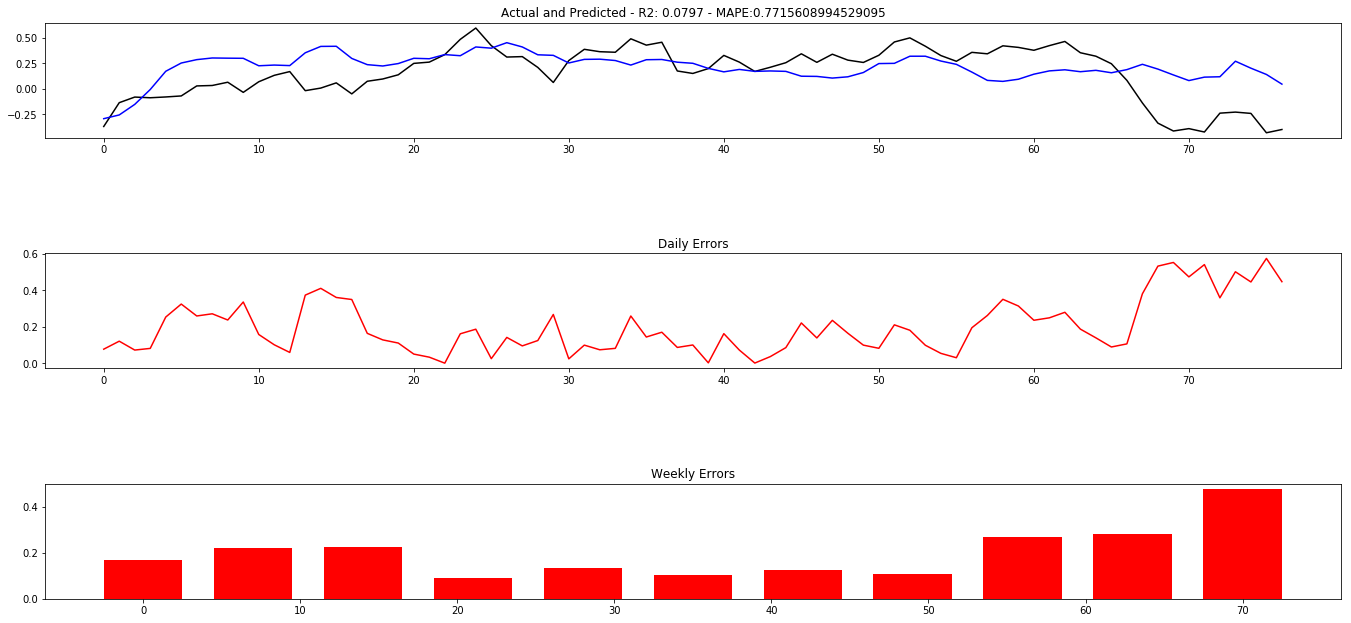

In [24]:
plot_prediction(Y_val, model.predict(X_val))

## Test

In [25]:
norm_test_monthly_prices = minmax_norm(test_monthly_prices, a=-1, b=1)
norm_test_monthly_volumes = minmax_norm(test_monthly_volumes, a=-1, b=1)

### NOT normalized

In [26]:
#normalized d_list
d_list = [test_monthly_prices, test_monthly_volumes]
windows = [6,8,12]
test_data_dict = get_data_chunks(d_list, windows)

index 44 is out of bounds for axis 0 with size 44
index 44 is out of bounds for axis 0 with size 44
index 44 is out of bounds for axis 0 with size 44


### Normalized

In [27]:
#normalized d_list
d_list = [norm_test_monthly_prices, norm_test_monthly_volumes]
windows = [6,8,12]
norm_test_data_dict = get_data_chunks(d_list, windows)

index 44 is out of bounds for axis 0 with size 44
index 44 is out of bounds for axis 0 with size 44
index 44 is out of bounds for axis 0 with size 44


### result

In [28]:
X_test = norm_test_data_dict[w]['X']
#Y_test = test_data_dict[w]['Y']
not_norm_true_values = test_data_dict[w]['Y']

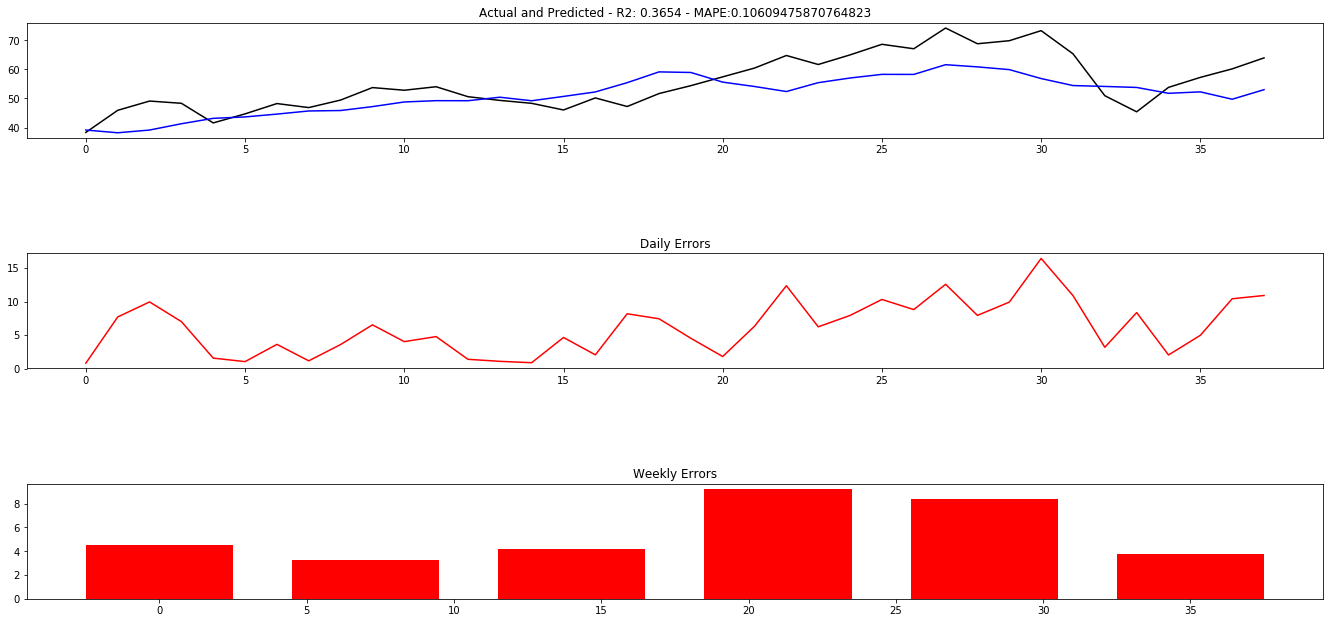

In [29]:
pred_y = model.predict(X_test)
pred_yy = minmax_denorm(test_monthly_prices, pred_y, a=-1, b=1)
plot_prediction(not_norm_true_values, pred_yy)